Resources used: 
https://kalaharijournals.com/resources/SP-Vol.6_53.pdf
https://iopscience.iop.org/article/10.1088/1742-6596/1246/1/012030/pdf

In [4]:
import tensorflow as tf
import numpy as np
import csv
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, sosfilt, sosfreqz, cheby1
#This function takes in the ecg data(in csv format) from a file(individual patient).
#The ecg data is stripped from its header and then returned as a 2d-numpy array.
def takeData(fileName):
    with open(fileName) as csv_file:
      list1 = []
      list2 = []
      reader = csv.reader(csv_file, delimiter=',')
      flag = True
      for row in reader:
        if flag:
          flag = False
          continue
        list1.append(row[1])
        list2.append(row[2])
        
        
    return np.array([list1, list2]).astype(float)

#This function to used to subsample the data from a single patient.
#The first parameter is an array or list and the second parameter is the frequency that the data will be subsampled at.
def subsample(data, Fs):
    list1 = []
    list2 = []
    for i in range(len(data[0])):
        if (i+1) % Fs == 0:
            list1.append(data[0][i])
            list2.append(data[1][i])
        i += 1
    return np.array([list1, list2])
            
#This function returns a butterworth bandpass filter object for a given lower and higher frequency cutoff.
def butter_bandpass(lowcut, highcut, fs, order=3):
        nyq = 0.5 * fs
        low = lowcut / nyq
        high = highcut / nyq
        sos = butter(order, [low, high], analog=False, btype='band', output='sos')
        return sos

#This function passes the given data through a butterworth bandpass filter with a given lower and higher frequency cutoff.
def butter_bandpass_filter(data, lowcut, highcut, fs, order=3):
        sos = butter_bandpass(lowcut, highcut, fs, order=order)
        x = sosfilt(sos, data[0])
        y = sosfilt(sos, data[1])
        return np.array([x,y])
#This function returns a chebychev type 1 bandpass filter object for a given lower and higher frequency cutoff.
def cheby1_bandpass(lowcut, highcut, fs, order=3):
        nyq = 0.5 * fs
        low = lowcut / nyq
        high = highcut / nyq
        sos = cheby1(order, 1, [low, high], analog=False, btype='band', output='sos')
        return sos

#This function passes the given data through a chebychev type 1 bandpass filter with a given lower and higher frequency cutoff.
def cheby1_bandpass_filter(data, lowcut, highcut, fs, order=3):
        sos = cheby1_bandpass(lowcut, highcut, fs, order=order)
        x = sosfilt(sos, data[0])
        y = sosfilt(sos, data[1])
        return np.array([x,y])

#This function plots the data from a given patient for a specified range of samples on the x-axis.
#It is possible to specify either the Ml2 reading or the v1/v2/v4/v5 or both to be plotted.
def plot_heart_beats(filtered, start=0, end=3600, ml2_or_v5 = "both"):
    if (ml2_or_v5 == "ml2"):
        plt.plot(range(start,end), filtered[0][start:end], color="blue")
        plt.legend(['ml2'])
    elif (ml2_or_v5 == "v5"):
        plt.plot(range(start,end), filtered[1][start:end], color="orange")
        plt.legend(['v5'])
    else:
        plt.plot(range(start,end), filtered[0][start:end], color="blue")
        plt.plot(range(start,end), filtered[1][start:end], color="orange")
        plt.legend(['MLII', 'V5'])

#This function normalizes the given data to a range between 0 and 1.
def normalise_y_axis(data, start=2100):
    min1 = np.amin(data[0][start:])
    max1 = np.amax(data[0][start:])
    diff1 = max1 - min1

    min2 = np.amin(data[1][start:])
    max2 = np.max(data[1][start:])
    diff2 = max2 - min2

    for i in range(start, len(data[0])):
        data[0][i] = (data[0][i] - min1)/diff1
        data[1][i] = (data[1][i] - min2) / diff2
        
    return data

    

length before: 650000
length after: 325000


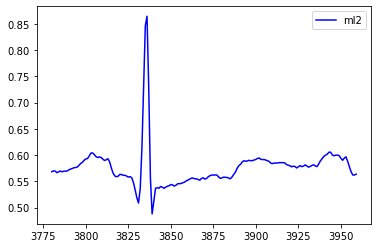

In [5]:
    

data = takeData('ecgData/100.csv')


filtered = butter_bandpass_filter(data, 0.4, 45, 360)

filtered1 = cheby1_bandpass_filter(data, 0.4, 45, 360)

print("length before: " + str(len(filtered[0])))

filtered = subsample(filtered, 2)

print("length after: " + str(len(filtered[1])))

filtered = normalise_y_axis(filtered)



plot_heart_beats(filtered, 3780, 3960, "ml2")

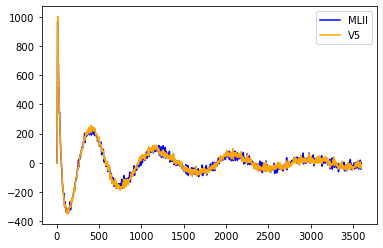

In [5]:
plot_heart_beats(filtered1, 0, 3600)


Step 1: Import the data into some kind of structure (likely numpy)
Step 2: Pass through a frequency band-pass filter to cancel power line oscillations and slow drifts, "butterworth filter" - cutoff 0.4Hz and 45Hz.
Step 3: Deal with missing values

In [70]:
#This is code is trying to help determine the length of the average heartbeat in number of samples.
import os

path = "./ecgData\mitbih_database"

files = os.listdir(path)
newFiles = []
for file in files:
    if file[-1] == "t":
        newFiles.append(file)
        
total = 0
fileNum = 0    
for file in newFiles:
    with open("ecgData/mitbih_database/" + file) as annotationFile:
        total += (len(annotationFile.readlines()))
        fileNum += 1
avgNumAnnotations = total / fileNum
print(fileNum)

print(650000/avgNumAnnotations)


    


48
276.85345401304403


In [111]:


#This is code is trying to help determine the length of the longest heartbeat in number of samples.
path = "./ecgData\mitbih_database"
files = os.listdir(path)
newFiles = []
for file in files:
    if file[-1] == "t":
        newFiles.append(file)
        

maxHeartLength = 0
strings = []
for annotations in newFiles:
    prevSample = 0
    heartLength = 0
    with open("ecgData/mitbih_database/" + annotations) as file:
        i = 0
        for line in file:
            if i == 0:
                i+=1
                continue
            heartLength = int(line.split()[1]) - prevSample
            #print(heartLength)
            if (heartLength > 500):
                list1 = []
                list1.append(annotations)
                list1.append(str(i))
                strings.append(list1)
            if(heartLength > maxHeartLength): 
                maxHeartLength = heartLength
            prevSample = int(line.split()[1])
            i+=1


print("maxHeartLength: " + str(maxHeartLength))
print(len(strings))
print(strings)



maxHeartLength: 2114
739
[['106annotations.txt', '225'], ['106annotations.txt', '1882'], ['106annotations.txt', '1886'], ['106annotations.txt', '1894'], ['106annotations.txt', '1901'], ['106annotations.txt', '1905'], ['106annotations.txt', '1909'], ['106annotations.txt', '1913'], ['106annotations.txt', '1920'], ['106annotations.txt', '1927'], ['106annotations.txt', '1935'], ['106annotations.txt', '1984'], ['106annotations.txt', '1991'], ['106annotations.txt', '1999'], ['108annotations.txt', '230'], ['108annotations.txt', '557'], ['108annotations.txt', '710'], ['108annotations.txt', '721'], ['108annotations.txt', '828'], ['108annotations.txt', '895'], ['108annotations.txt', '935'], ['108annotations.txt', '1117'], ['108annotations.txt', '1131'], ['108annotations.txt', '1167'], ['108annotations.txt', '1180'], ['108annotations.txt', '1190'], ['108annotations.txt', '1411'], ['108annotations.txt', '1464'], ['114annotations.txt', '81'], ['114annotations.txt', '119'], ['114annotations.txt', '1